In [1]:
# All of the packages that need to be downloaded
%%capture
!pip install overpy
!pip install geojson
!pip install geojsonio
!pip install openrouteservice
!pip install geopandas
!pip install plotly==4.3.0
#!pip install fuzzywuzzy
#!pip install python-Levenshteinz
!pip install fuzzyset
!pip install arcgis
!pip install rasterio
!pip install GDAL
#!easy_install Rtree
#!pip install georasters
!pip install -U googlemaps

In [2]:
import os 
import re
from datetime import datetime
import json
#from fuzzywuzzy import fuzz, process
import fuzzyset
from datetime import datetime, timedelta
import numpy as np
import pandas as pd # data import and maniplation 
import seaborn as sns
import matplotlib.pyplot as plt # data visualization 
import plotly.offline as py
import plotly.graph_objects as go

# geospatial packages
import overpy 
#import geojson
import geojsonio
from geojson import Feature, FeatureCollection, Point
import openrouteservice
import geopandas
import gdal
#import rasterio
#import rasterio.plot
import googlemaps
#import georasters as gr
#from arcgis.geoenrichment import *
#from arcgis.gis import GIS

from sklearn import datasets, linear_model # regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # data split 
from random import randint
import fiona

sns.set_style("whitegrid")
api = overpy.Overpass()
location_allocation = True

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# if I want to change between google collab or spyder 
if True:
    from google.colab import files
    files.upload()

Saving export.geojson to export.geojson
Saving Nepal Cumulative Burns 2014-19 copy.xlsx to Nepal Cumulative Burns 2014-19 copy.xlsx
Saving Nepal_Validation - Sheet1.csv to Nepal_Validation - Sheet1.csv


In [4]:
# data input
df = pd.read_excel('Nepal Cumulative Burns 2014-19 copy.xlsx')
hosp_df = pd.read_csv('Nepal_Validation - Sheet1.csv')
hosp_df['gps'] = list(zip(hosp_df['hosp_corr_lon'].fillna(""), hosp_df['hosp_corr_lat'].fillna("")))
df = df[df['Year'] != 2014]

# removes duplicate
df['Program'] = df['Program'].apply(lambda x: str(x).lower().strip().replace('silf', 'self').replace('wonder work', 'ww').replace('wonderwork', 'ww').replace('sef', 'self').replace('selff', 'self').replace('self1', 'self'))

# gives a patient number proxy 
#df['patient'] = np.arange(len(df))
df['Name of Hospital'] = df['Name of Hospital'].apply(lambda x: x if str(x) == 'nan'  else str(x).strip().lower())
df = df.sort_values( 'Name of Hospital', ascending = True).reset_index()
df['Hosp_true_name'] = hosp_df['OSM'].fillna(hosp_df['Hospital Name change'])
df['hosp_cor_gps'] = hosp_df['gps']
df['hosp_cor_gps'] = [ i if i != ("","") else np.nan for i in df['hosp_cor_gps']]

# importing geojson from overpressturbo, formatting
nepal_map = geopandas.read_file("export.geojson")
nepal_map['name:en'] = nepal_map['name:en'].apply(lambda x: str(x).lower().replace('sindhupalchowk', 'sindhupalchok'))
nepal_map['id'] = np.arange(len(nepal_map))

Geocoding:

Open steet map 
https://wiki.openstreetmap.org/wiki/Tag:boundary%3Dadministrative#10_admin_level_values_for_specific_countries

Admin level:
- 3: Province
- 4: Dev Region
- 5: Zones
- 6: Districts
- 7: Municipalities 
- 8 Cities/Villages

# Overpass/OSM queries

In [5]:
# DISTRICT query 
# This is where you can call the tags for the particular id then get the meta data 
# result.relations[1].tags, gets the center lat for the relation 

district = api.query("""
[out:json];
area["ISO3166-1"="NP"][admin_level = 2]->.boundaryarea;  
(
  rel(area..boundaryarea)[admin_level="6"];
);
out center meta;""")

district_map = {}
error = 0
for rel in district.relations:
  if (rel.tags.get('name:en', "empty") != 'empty'):
    district_map[rel.tags['name:en'].lower()] = [float(rel.center_lon),float(rel.center_lat)]
  elif (rel.tags.get('name', "empty") != 'empty'):
    district_map[rel.tags['name'].lower()] = [float(rel.center_lon),float(rel.center_lat)]
  else: 
    district_map[error] = rel
    error += 1
district_map.pop('error', None)

In [6]:
# gets all villages in Nepal
villages = api.query("""
[out:json];
area["ISO3166-1"="NP"][admin_level = 2]->.boundaryarea;  
(
  rel(area..boundaryarea)[admin_level="8"]; 
);
out center meta;
""")

village_map = {}
error = 0
for rel in villages.relations:
  if (rel.tags.get('name:en', "empty") != 'empty'):
    village_map[rel.tags['name:en'].lower()] = [float(rel.center_lon),float(rel.center_lat)]
  elif (rel.tags.get('name', "empty") != 'empty'):
    village_map[rel.tags['name'].lower()] = [float(rel.center_lon),float(rel.center_lat)]
  else: 
    village_map[error] = rel
    error += 1
village_map.pop('error', None)

# Formatting address and district naming

In [7]:
# Processes the formatting and spelling of addresses
df['Address'] = df['Address'].apply(lambda x: str(x).lower().strip().replace('ktm', 'kathmandu').replace('accham', 'achham').replace('agrakhanchi', 'arghakhanchi').replace('argakhachi', 'arghakhanchi').replace('argakhanchi', 'arghakhanchi').replace('arghakhachi', 'arghakhanchi').replace('baglong', 'baglung').replace('bajhang', 'bajang').replace('bhairawa', 'bhairahawa').replace('bharatpur','bhaktapur').replace('bhkatapur','bhaktapur').replace('butuwal','butwal').replace('bajang','bajhang').replace('chayanpur','chainpur').replace('dailekha','dailekh').replace('dhangadi','dhangari').replace('dhanusa','dhanusha').replace('dhanushaa','dhanusha').replace('dhulekhel','dhulikhel').replace('dolakaha','dolakha').replace('dolkaha','dolakha').replace('illam','ilam').replace('ithari','itahari').replace('ittahari','itahari').replace('kapilbastu','kapilvastu').replace('kavrepalanchowk','kavrepalanchok').replace('kavre','kavrepalanchok').replace('kirtipipur','kirtipur').replace('kohalpir','kohalpur').replace('kuleshor','kuleshwor').replace('lamgunj','lamjung').replace('llitpur','lalitpur').replace('mahatori','mahottari').replace('mahatari','mahottari').replace('mahotari','mahottari').replace('makawanpur','makwanpur').replace('nawalparashi','nawalparasi').replace('nawalparasi','nawalparasi').replace('nepaljung','nepalgunj').replace('okahaldhunga','okhaldhunga').replace('okaldhunga','okhaldhunga').replace('parsha','parsa').replace('pokahara','pokhara').replace('ramechap','ramechhap').replace('samkhuwasabha','sankhuwasabha').replace('sankhuwasava','sankhuwasabha').replace('sakhawasaba','sankhuwasabha').replace('sangjhya','sanghiya').replace('saralahi','sarlahi').replace('shankhuwashabha','sankhuwasabha').replace('shyanja','shyangja').replace('simra','simara').replace('simra','simara').replace('sindhui','sindhuli').replace('sindhupalchowk','sindhupalchok').replace('sinduli','sindhuli').replace('sindupalchok','sindhupalchok').replace('sindupalchowk','sindhupalchok').replace('snkhuwasabha','sankhuwasabha').replace('syanja','syangja').replace('syanjha','syangja').replace('tanahu','tanahun').replace('taplegunj','taplejung').replace('taudhaha','taudaha').replace('terathum','tehrathum').replace('udaypur','udayapur'))
df['Address2'] = df['Address'].apply(lambda x: str(x).lower().strip().replace(', ', ',').replace('- ', '-').split(','))

# extracts district and village from the query / shapefile
df['district'] = df['Address2'].apply(lambda x: [y for y in x if y in list(nepal_map['name:en'].unique())]).apply(lambda x: x[0] if x != [] else '')
df['village']  = df['Address2'].apply(lambda x: [y for y in x if y in list(village_map.keys())]).apply(lambda x: x[0] if x != [] else '')
df['district_gps'] = df['district'].apply(lambda x: district_map[x] if x in district_map.keys() else '')
df['village_gps']  = df['village'].apply(lambda x: village_map[x] if x in village_map.keys() else '')

# Merging gps with location data

In [8]:
# district/village df are in an odd data format 
# turning both into a df  
df_distmap = pd.Series(district_map, name = 'dist_map')
df_distmap.index.name = 'district'
df_distmap = df_distmap.reset_index()

df_villmap = pd.Series(village_map, name = 'vill_map')
df_villmap.index.name = 'village'
df_villmap = df_villmap.reset_index()

In [9]:
# Creating a column of patient counters  
# * Gotta convert to df first before anything or else python thinks its a relation 
nepal_map = nepal_map.merge(pd.DataFrame(df.groupby(['district'])['district'].size().reset_index(name='counts'))[1:], how ='left' , left_on = 'name:en', right_on = 'district')
nepal_map[['counts']] = nepal_map[['counts']].fillna(value = 0)

vill_merge = pd.DataFrame( df.groupby(['village'])['village'].size().reset_index(name='counts') )[1:].merge(df_villmap, how ='left', on = 'village' )
vill_merge['long'] = vill_merge['vill_map'].apply(lambda x: x[0])
vill_merge['lat'] = vill_merge['vill_map'].apply(lambda x: x[1])

# Converting the city coords into a geopandas data df
nepal_cities = geopandas.GeoDataFrame(vill_merge, geometry=geopandas.points_from_xy(vill_merge.long, vill_merge.lat))
#dist_merge = df[df['village'] == ''][['patient','district']].merge(df_distmap, on = 'district' )
#vill_merge = df[df['district'] == ''][['patient','village']].merge(df_villmap, on = 'village' )

# Hospital name merge

In [10]:
# Gets all healthcare/clinics in nepal
if location_allocation:
  query = """ node(area..boundaryarea)[amenity ='hospital'];
  way(area..boundaryarea)[amenity ='hospital'];    
  way(area..boundaryarea)[building ='hospital'];"""
else:
  query = """  node(area..boundaryarea)[amenity ='clinic'];
  node(area..boundaryarea)[amenity ='hospital'];
  way(area..boundaryarea)[amenity ='hospital'];    
  way(area..boundaryarea)[building ='hospital'];"""
result = api.query("""
[out:json];
area["ISO3166-1"="NP"][admin_level = 2]->.boundaryarea;  
({0}
);
out center meta;
""".format(query))

# converts the query to a usable dataframe
hosp_map = {}
for way in result.ways:
  if (way.tags.get('name:en', "empty") != 'empty'):
    hosp_map[way.tags['name:en'].lower()] = [float(way.center_lon),float(way.center_lat)]
  elif (way.tags.get('name', "empty") != 'empty'):
    hosp_map[way.tags['name'].lower()] = [float(way.center_lon),float(way.center_lat)]
  else: 
    hosp_map['error'] = way
for node in result.nodes:
  if (node.tags.get('name:en', "empty") != 'empty'):
    hosp_map[node.tags['name:en'].lower()] = [float(node.lon),float(node.lat)]
  elif (node.tags.get('name', "empty") != 'empty'):
    hosp_map[node.tags['name'].lower()] = [float(node.lon),float(node.lat)]
  else: 
    hosp_map['error'] = node

In [11]:
df_hosp_map = pd.Series(hosp_map, name = 'df_hosp_map')
df_hosp_map.index.name = 'hosp'
df_hosp_map = df_hosp_map.reset_index()

c = fuzzyset.FuzzySet()
for i in list(df_hosp_map['hosp'].unique()):
  c.add(str(i))
  
df['extract_hosp'] = df['Hosp_true_name'].apply(lambda x: c.get(str(x))[0][1] if str(x) != 'nan' else '') #.to_csv('test.csv')
df['hosp_gps'] = df['extract_hosp'].apply(lambda x: hosp_map[x] if x != '' else  np.nan )
df['hosp_gps_full'] = df.hosp_gps.fillna(df['hosp_cor_gps'])

In [12]:
def routing_df_mapping(location,gps, df): 
  test = pd.DataFrame(df[[location,gps]].copy().drop_duplicates(location), 
                      columns = [location,gps]).reset_index().assign(route = np.nan).assign(route_open = np.nan).replace('error', '')
  test = test[test[location] != "" ]
  test['route'] = test['route'].apply(lambda x: {})
  test['route_open'] = test['route_open'].apply(lambda x: {})
  test = test.join(pd.DataFrame(test[gps].values.tolist(), columns = ['lat', 'long']))
  #test.index = test.index + 1
  return test

In [ ]:
hosp_geocode = routing_df_mapping('extract_hosp','hosp_gps_full',df)
vill_geocode = routing_df_mapping('village','village_gps',df)
dist_geocode = routing_df_mapping('district','district_gps',df)

In [13]:
# for argis location allocation modeling 
if location_allocation:
  routing_df_mapping('hosp', 'df_hosp_map', df_hosp_map).to_csv('hosp_candidate.csv')

# Routing:

- Only way to work is if its next to a road so centriod might not really work
- Villages would work in theory
- Would have to calculate some sort of average time/speed in a 500 m radius to make it equiravlent 

In [ ]:
# Google maps api 
#api_key = open(r'api_keys.txt').read()
#gmaps = googlemaps.Client(key = api_key, queries_per_second=30, retry_timeout = 360)
#!curl ipecho.net/plain

# Alternate routing catch
#https://github.com/GIScience/openrouteservice-py
#5b3ce3597851110001cf62484982bdf5b33d477e85212c8fa76de5af 
#5b3ce3597851110001cf62484f6201ddb7ff4befa031f0b88b370d4c #main
from openrouteservice import convert
client = openrouteservice.Client(key='5b3ce3597851110001cf62484f6201ddb7ff4befa031f0b88b370d4c') # Specify your personal API key

In [ ]:
kirtipuer_gps = (27.666664,85.2833322)
kirtipuer_gps_open = (85.2833322 ,27.666664)
now = datetime.now()
import time
def google_maps_gps(df_raw, time_delay, gps_string):
  print('start')
  df = df_raw.copy()
  for i in range(len(df)):
    if (df[gps_string][i] != ''):
      try:  
        gps_pull = gmaps.directions((df[gps_string][i][1], df[gps_string][i][0]),kirtipuer_gps,mode="driving")
        if gps_pull != []:
          df['route'][i] = gps_pull[0]
        else: 
          df['route_open'][i] = client.directions(((df[gps_string][i][0], df[gps_string][i][1]),kirtipuer_gps_open), radiuses = [50000,350])
      except Exception as e:
        print(e)
      time.sleep(time_delay)


def orsm_gps(df, time_delay, gps_string):
  print('start')
  for i in range(len(df)):
    if (df[gps_string][i] != ''):
      try:
          df['route_open'][i] = client.directions(((df[gps_string][i][0], df[gps_string][i][1]),kirtipuer_gps_open), 
                                                    radiuses = [50000,350], extra_info = ['waytype', 'waycategory'])
      except Exception as errh:
         df['route_open'][i] = errh
    else:
      df['route_open'][i] = 'empty'
    time.sleep(time_delay)

In [ ]:
#google_maps_gps(hosp_geocode, kirtipuer_gps, 2, 'hosp_gps')
#google_maps_gps(dist_geocode, kirtipuer_gps, 2, 'district_gps')
#google_maps_gps(vill_geocode, kirtipuer_gps, 2, 'village_gps')
orsm_gps(hosp_geocode, 2, 'hosp_gps_full')
orsm_gps(dist_geocode, 2, 'district_gps')
orsm_gps(vill_geocode, 2, 'village_gps')

start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



start


In [ ]:
# for google maps extraction 
def dict_gps_extraction(dataset, choice):
  dataset['route_sub'] = dataset.route.apply(pd.Series).legs
  dataset = dataset.merge(dataset.route_sub.apply(pd.Series)[0].apply(pd.Series)[['distance',choice]], left_index= True, right_index= True)
  return dataset.merge(dataset[choice].apply(pd.Series)[['text','value']], left_index= True, right_index= True)

def duration_distance(choice, method):
        return df.merge(pd.DataFrame(hosp_geocode[['extract_hosp',method]], 
                               columns = ['extract_hosp',method]).rename(columns={ method: choice }), 
                               how = 'left', on = 'extract_hosp' ).merge(
                  pd.DataFrame(dist_geocode[['district',method]], 
                               columns = ['district',method]).rename(columns={ method: choice + '_dist'}), 
                               how = 'left', on = 'district' ).merge(
                  pd.DataFrame(vill_geocode[['village',method]], 
                               columns = ['village',method]).rename(columns={ method: choice+ '_vill'}), 
                              how = 'left', on = 'village' )

def dict_gps_extract_open(dataset, choice):
  df = dataset.merge(dataset.route_open.apply(pd.Series).routes.apply(pd.Series)[0].apply(pd.Series).segments.apply(pd.Series)[0].apply(pd.Series)[['distance', 'duration']], left_index= True, right_index= True)
  df['duration_relative'] = (df['duration']*2)/60
  return df

In [ ]:
if True:
  hosp_geocode = dict_gps_extract_open(hosp_geocode, 'duration')
  dist_geocode = dict_gps_extract_open(dist_geocode[dist_geocode.route_open != 'empty'], 'duration')
  vill_geocode = dict_gps_extract_open(vill_geocode[vill_geocode.route_open != 'empty'], 'duration')
else:
  hosp_geocode = dict_gps_extraction(hosp_geocode, 'duration')
  dist_geocode = dict_gps_extraction(dist_geocode, 'duration')
  vill_geocode = dict_gps_extraction(vill_geocode, 'duration')

In [ ]:
import dateutil.parser
df = duration_distance('duration','duration_relative')
df['duration_full'] = df.duration.fillna(df.duration_vill).fillna(df.duration_dist)
df['Date /Time of burn injury'] = df['Date /Time of burn injury'].apply(lambda x: dateutil.parser.parse(str(x.replace('2.019','2019').replace('..','.').replace('31.4', '31.5').replace('1015','2015')), fuzzy =True, dayfirst = True) if type(x) == str else x)
df['Date/Time of admission'] = df['Date/Time of admission'].apply(lambda x: dateutil.parser.parse(str(x.split('/')[0].replace(',','.').replace('18thJan', '18th Jan').replace('..','.').replace('31.4', '31.5')), fuzzy =True, dayfirst = True) if type(x) == str else x)
df['Date of 1st Exc'] = df['Date of 1st Exc'].apply(lambda x: dateutil.parser.parse(str(x.replace('//','/').replace(',','.')), fuzzy =True, dayfirst = True) if ((type(x) == str) & (x != 'm')) else np.nan)
df['Time of Burn'] = df['Time of Burn'].apply(lambda x: dateutil.parser.parse(str(x.replace('.pm', ' pm').replace('.am', ' am').replace('.',':')), fuzzy =True, dayfirst = True).time() if type(x) == str else x)
df['Time of Admission'] =df['Time of Admission'].apply(lambda x: dateutil.parser.parse(str(x.replace('.pm', ' pm').replace('.am', ' am').replace('.',':').replace('mn','pm')), fuzzy =True, dayfirst = True).time() if type(x) == str else x)
df['datetime_burn'] = df.apply(lambda x : pd.datetime.combine(x['Date /Time of burn injury'],x['Time of Burn']) if ((type(x['Date /Time of burn injury']) == datetime) & (type(x['Time of Burn']) == type(datetime.today().time() ))) else x['Date /Time of burn injury'] , 1 )
df['datetime_admission'] = df.apply(lambda x : pd.datetime.combine(x['Date/Time of admission'],x['Time of Admission']) if ((type(x['Date/Time of admission']) == datetime) & (type(x['Time of Admission']) == type(datetime.today().time() ))) else x['Date/Time of admission'] , 1 )
df['time_between_injury_admission'] = df['datetime_admission'] - df['datetime_burn'] 
df['admission_to_1st_exc'] = df['Date of 1st Exc'] - df['datetime_admission'] 
df['injury_to_1st_exc'] = df['Date of 1st Exc'] - df['datetime_burn'] 
df['seconds_between_injury_admission'] = df['time_between_injury_admission'].apply(lambda x: x.seconds + x.days*12*60*60 if type(x) == timedelta else x)
df['seconds_admission_to_1st_exc'] = df['admission_to_1st_exc'].apply(lambda x: x.seconds + x.days*12*60*60 if type(x) == timedelta else x)
df['seconds_injury_to_1st_exc'] = df['injury_to_1st_exc'].apply(lambda x: x.seconds + x.days*12*60*60 if type(x) == timedelta else x)
df.to_csv('Nepal_patients_full.csv')

In [ ]:
df.to_csv('Nepal_patients_full.csv')

NameError: ignored

In [ ]:
df['time_between_injury_admission'].apply(lambda x: type(x))

0                    <class 'float'>
1       <class 'datetime.timedelta'>
2       <class 'datetime.timedelta'>
3       <class 'datetime.timedelta'>
4       <class 'datetime.timedelta'>
                    ...             
2006                 <class 'float'>
2007                 <class 'float'>
2008    <class 'datetime.timedelta'>
2009    <class 'datetime.timedelta'>
2010    <class 'datetime.timedelta'>
Name: time_between_injury_admission, Length: 2011, dtype: object

In [ ]:
# Regression - dependent admission condition (good vs ANY infection) 
#a. time from injury to admission b. travel time not distance c. specific places (hosp) proportions of patients admitted in poor condition vs admitted in fine condition (any problems --> poor )
#d. days treated at another - Are patient inapprop held e. sweet spot of pre transfer time (burn size, area of burned) - data driven
df.head()

,index,S NO,Year,Program,Age (yrs),Male,Female,Address,Baux Score,ABSI,Flame,Lightning,Scald,Electrical,Acid,Alkali,Steam,Contact,Others,incident inside house,At cooking place,incident outside house,At work,Suicide,Homicide,Date /Time of burn injury,Time of Burn,Date/Time of admission,Time of Admission,Time Elapsed,Date of Discharge,ALL Total Hosp Stay,Mortality,cause of death/day of death(post burn),Date of Death,Post burn Day of Death,weight at admission,weight at discharge,Weight Loss,Total days in ICU,...,Resistance.4,MRSA.4,MDR.4,5RD C/S,Date.7,Organism.6,Sensitive.4,Resistance.5,6RD C/S,Date.8,Organism.7,Sensitive.5,Resistance.6,7RD C/S,Date.9,Organism.8,Sensitive.6,Resistance.7,LAMA.1,DOR,Septic shock,Hosp_true_name,hosp_cor_gps,Address2,district,village,district_gps,village_gps,extract_hosp,hosp_gps,hosp_gps_full,duration,duration_dist,duration_vill,duration_full,datetime_burn,datetime_admission,time_between_injury_admission,admission_to_1st_exc,injury_to_1st_exc
0,780,120,2017,self,48,1,NaN,dhoti,50,5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2017-03-19 00:00:00,NaN,90days,30.3.2017,11,NaN,NaN,NaN,NaN,59,NaN,59,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Acham Hospital,"(81.2562267, 29.134940399999998)",[dhoti],,,,,asha hospital,"[84.4333861, 27.6809481]","[84.4333861, 27.6809481]",265.863333,NaN,NaN,265.863333,NaN,2017-03-19 00:00:00,NaN,"2 days, 0:00:00",NaN
1,604,317,2016,self,11,NaN,1.0,birjung,21,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,2016-11-10 00:00:00,NaN,2016-11-13 00:00:00,NaN,3,25.11.2016,12,NaN,NaN,NaN,NaN,34,32,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Advanced Hospital,"(84.87151329999999, 27.0074727)",[birjung],,,,,cancer hospital,"[85.527116, 27.6336888]","[85.527116, 27.6336888]",55.756667,NaN,NaN,55.756667,2016-11-10 00:00:00,2016-11-13 00:00:00,"3 days, 0:00:00","5 days, 0:00:00","8 days, 0:00:00"
2,1092,432,2017,risop,1,1,NaN,bhaktapur,6,3,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,2017-11-18 00:00:00,NaN,2017-11-18 00:00:00,NaN,0,26.11.2017,8,NaN,NaN,NaN,NaN,10.5,11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alka Hospital,NaN,[bhaktapur],bhaktapur,,"[85.4384216, 27.6742108]",,alka hospital,"[85.3150696, 27.6745499]","[85.3150696, 27.6745499]",14.140000,41.856667,NaN,14.140000,2017-11-18 00:00:00,2017-11-18 00:00:00,0:00:00,"1 day, 0:00:00","1 day, 0:00:00"
3,1058,397,2017,self,28,NaN,1.0,lalitpur,41,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,2017-10-30 00:00:00,NaN,2017-10-30 00:00:00,NaN,0,10.11.2017,11,NaN,NaN,NaN,NaN,60,58,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alka Hospital,NaN,[lalitpur],lalitpur,,"[85.3374784, 27.5481484]",,alka hospital,"[85.3150696, 27.6745499]","[85.3150696, 27.6745499]",14.140000,59.070000,NaN,14.140000,2017-10-30 00:00:00,2017-10-30 00:00:00,0:00:00,"2 days, 0:00:00","2 days, 0:00:00"
4,461,174,2016,nan,22,1,NaN,badegaun,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2016-06-06 00:00:00,NaN,2016-06-08 00:00:00,NaN,2,19.6.2016,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alka Hospital,NaN,[badegaun],,,,,alka hospital,"[85.3150696, 27.6745499]","[85.3150696, 27.6745499]",14.140000,NaN,NaN,14.140000,2016-06-06 00:00:00,2016-06-08 00:00:00,"2 days, 0:00:00","1 day, 0:00:00","3 days, 0:00:00"


In [ ]:
# time from injury to admission 
#df[['time_between_injury_admission', 'Baux Score','Mortality','Gangene','Treatment in another hospital? (1=yes,0=no)','Days Treated in another hospital', 'Infection at admission','']]

#df[['duration_full', '']]
df[(df['Infection at the admision'] == 1) &(df['Infection at admission'] == 1)]

,index,S NO,Year,Program,Age (yrs),Male,Female,Address,Baux Score,ABSI,Flame,Lightning,Scald,Electrical,Acid,Alkali,Steam,Contact,Others,incident inside house,At cooking place,incident outside house,At work,Suicide,Homicide,Date /Time of burn injury,Time of Burn,Date/Time of admission,Time of Admission,Time Elapsed,Date of Discharge,ALL Total Hosp Stay,Mortality,cause of death/day of death(post burn),Date of Death,Post burn Day of Death,weight at admission,weight at discharge,Weight Loss,Total days in ICU,...,Resistance.4,MRSA.4,MDR.4,5RD C/S,Date.7,Organism.6,Sensitive.4,Resistance.5,6RD C/S,Date.8,Organism.7,Sensitive.5,Resistance.6,7RD C/S,Date.9,Organism.8,Sensitive.6,Resistance.7,LAMA.1,DOR,Septic shock,Hosp_true_name,hosp_cor_gps,Address2,district,village,district_gps,village_gps,extract_hosp,hosp_gps,hosp_gps_full,duration,duration_dist,duration_vill,duration_full,datetime_burn,datetime_admission,time_between_injury_admission,admission_to_1st_exc,injury_to_1st_exc
22,1382,226,2018,self,18,1,NaN,jhapa,44,5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2018-03-11 00:00:00,NaN,2018-03-24 00:00:00,NaN,13,29.3.2018,5,NaN,NaN,NaN,NaN,60,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B & C Teaching Hospital,NaN,[jhapa],jhapa,,"[87.9128828, 26.583566]",,b & c teaching hospital,"[87.997455, 26.6447115]","[87.997455, 26.6447115]",717.023333,736.870000,NaN,717.023333,2018-03-11 00:00:00,2018-03-24 00:00:00,"13 days, 0:00:00",NaN,NaN
27,835,175,2017,risop,6,NaN,1.0,bajura,10,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-10-12 00:00:00,NaN,2017-04-18 00:00:00,NaN,6months,30.4.2017,12,NaN,NaN,NaN,NaN,15,NaN,15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Seti Zonal Hospital,NaN,[bajura],bajura,,"[81.4889304, 29.6105644]",,bheri zonal hospital,"[81.619702, 28.0528338]","[81.619702, 28.0528338]",787.486667,NaN,NaN,787.486667,2016-10-12 00:00:00,2017-04-18 00:00:00,"188 days, 0:00:00","3 days, 0:00:00","191 days, 0:00:00"
33,876,216,2017,self,35,NaN,1.0,bardibash,45,5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,2017-05-08 00:00:00,NaN,2017-05-14 00:00:00,NaN,6,23.5.2017,9,NaN,NaN,NaN,NaN,45,45,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bardibas Hospital,"(85.8567041, 26.9399489)",[bardibash],,,,,diyas hospital,"[85.3045908, 27.6527637]","[85.3045908, 27.6527637]",14.863333,NaN,NaN,14.863333,2017-05-08 00:00:00,2017-05-14 00:00:00,"6 days, 0:00:00","3 days, 0:00:00","9 days, 0:00:00"
49,875,215,2017,risop,23,1,NaN,bara,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2017-04-09 00:00:00,NaN,2017-05-05 00:00:00,NaN,30,25.5.2017,20,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bharatpur Hospital,NaN,[bara],bara,,"[85.0685065, 27.1074125]",,bhaktapur hospital,"[85.4219227, 27.6723866]","[85.4219227, 27.6723866]",38.253333,237.546667,NaN,38.253333,2017-04-09 00:00:00,2017-05-05 00:00:00,"26 days, 0:00:00","6 days, 0:00:00","32 days, 0:00:00"
51,892,232,2017,self,19,1,NaN,nawalparasi,23,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2017-04-29 00:00:00,NaN,2017-05-29 00:00:00,NaN,30,16.6.2017,18,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TU Teaching Hospital,NaN,[nawalparasi],nawalparasi,,,,b & c teaching hospital,"[87.997455, 26.6447115]","[87.997455, 26.6447115]",717.023333,NaN,NaN,717.023333,2017-04-29 00:00:00,2017-05-29 00:00:00,"30 days, 0:00:00","2 days, 0:00:00","32 days, 0:00:00"
99,880,220,2017,self,7,1,NaN,kailali,27,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2017-05-13 00:00:00,NaN,2017-05-15 00:00:00,NaN,2,20.5.2017,NaN,NaN,NaN,NaN,NaN,15,15,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Septi

# Potential location allocation model

https://github.com/apulverizer/pyspatialopt


In [ ]:
sl


# potential routing 
#https://github.com/GIScience/openrouteservice-py
from openrouteservice import convert
client = openrouteservice.Client(key='5b3ce3597851110001cf62484f6201ddb7ff4befa031f0b88b370d4c	') # Specify your personal API key
kirtipuer_gps = (85.2833322 ,27.666664)
start = 0

for i in range(len(hosp_geocode)):
  if (hosp_geocode['hosp_gps'][i] != ''):
    hosp_geocode['route_open'][i] = client.directions(((hosp_geocode['hosp_gps'][i][0], hosp_geocode['hosp_gps'][i][1]),kirtipuer_gps), optimize_waypoints= True)
  else:
    hosp_geocode['route_open'][i] = 'empty'

for i in range(len(dist_geocode)):
  if (dist_geocode['district_gps'][i] != ''):
    try:
      dist_geocode['route_open'][i] = client.directions(((dist_geocode['district_gps'][i][0], dist_geocode['district_gps'][i][1]),kirtipuer_gps), optimize_waypoints= True, radiuses = [50000,350])
    except Exception as errh:
     dist_geocode['route_open'][i] = errh
  else:
    dist_geocode['route_open'][i] = 'empty'

for i in range(len(vill_geocode)):
  if (vill_geocode['village_gps'][i] != ''):
    try:
      vill_geocode['route_open'][i] = client.directions(((vill_geocode['village_gps'][i][0], vill_geocode['village_gps'][i][1]),kirtipuer_gps), optimize_waypoints= True, radiuses = [50000,350])
    except Exception as errh:
     dist_geocode['route_open'][i] = errh
  else:
    vill_geocode['route_open'][i] = 'empty'



In [ ]:
hosp_geocode['route'][1]

In [ ]:
hosp_geocode['route_open'][1]

In [ ]:
  print(routes)

geometry = client.directions(coords)['routes'][0]['geometry']

decoded = convert.decode_polyline(geometry)

print(decoded)

In [ ]:
test['lon'] = test['vill_map'].apply(lambda x: x[0])
test['lat'] = test['vill_map'].apply(lambda x: x[1])

In [ ]:
fig = go.Figure(go.Choroplethmapbox(geojson=nepal_map_json, locations = nepal_map.id, z = nepal_map.counts,
                                    colorscale="magma",
                                    reversescale=True,
                                    marker_opacity=0.5, marker_line_width=1,
                                    hoverinfo = 'text+z',
                                    hovertext = nepal_map['name:en']))
fig.update_layout(layout)
fig.add_trace(go.Scattermapbox(
                  lat = vill_merge.lat,
                  lon = vill_merge.long,
                  mode = 'markers',
                  hoverinfo = 'text',
                  hovertext = vill_merge.village + ': ' + (vill_merge.counts).astype(str) ,
                  marker=go.scattermapbox.Marker(
                    #size=vill_merge.counts/7, coming back to this as it breaks with KTM 
                    size=6,
                    color='rgb(0,206,209)',
                    opacity=1.0
                  )
              ))
fig.add_trace(go.Scattermapbox(
                  lat = test.lat,
                  lon = test.lon,
                  mode = 'markers',
                  marker=go.scattermapbox.Marker(
                    #size=vill_merge.counts/7, coming back to this as it breaks with KTM 
                    size=6,
                    color='rgb(0,206,209)',
                    opacity=1.0
                  )
              ))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test2 = py.plot(fig, filename = 'nepal.html')

1. refer = 1 then hosp gps 
2. sample of hospital gps - boot strap - if came from a hosp but no name 
3. random sample of the admin unit 

* select seed for randomization 
- restrict year to 2016 =<

1. mapping of patients 
2. network analysis (dependent: gps of kirtipur | road network, assigned speed limit (1st, 2nd, 3rd), place of origin, overlay topograpgy ==> time variable 
3. Dependent variable = admission condition (good vs ANY infection) 
  a. time from injury to admission
  b. travel time not distance 
  c. specific places (hosp) proportions of patients admitted in poor condition vs admitted in fine condition 
   - any problems --> poor 

   
  d. days treated at another - Are patient inapprop held 
  e. sweet spot of pre transfer time (burn size, area of burned) - data driven 
4. After Jan
  a. location allocation model




# quick analysis

In [ ]:
nepal_post = pd.read_csv('Nepal_patients_duration.csv')
nepal_post['Flame'] = nepal_post['Flame'].fillna(0).replace(9,0)

TypeError: ignored

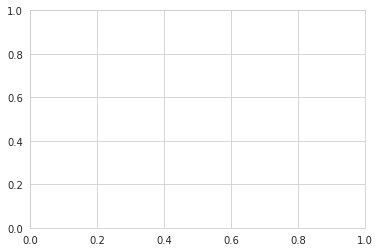

In [ ]:
ax = sns.regplot(data = nepal_post,
            x = 'duration_full', y = 'ALL Total Hosp Stay')

In [ ]:
nepal_post

,Unnamed: 0,index,S NO,Year,Program,Age (yrs),Male,Female,Address,Baux Score,ABSI,Flame,Lightning,Scald,Electrical,Acid,Alkali,Steam,Contact,Others,incident inside house,At cooking place,incident outside house,At work,Suicide,Homicide,Date /Time of burn injury,Time of Burn,Date/Time of admission,Time of Admission,Time Elapsed,Date of Discharge,ALL Total Hosp Stay,Mortality,cause of death/day of death(post burn),Date of Death,Post burn Day of Death,weight at admission,weight at discharge,Weight Loss,...,MDR.3,4RD C/S,Date.6,Organism.5,Sensitive.3,Resistance.4,MRSA.4,MDR.4,5RD C/S,Date.7,Organism.6,Sensitive.4,Resistance.5,6RD C/S,Date.8,Organism.7,Sensitive.5,Resistance.6,7RD C/S,Date.9,Organism.8,Sensitive.6,Resistance.7,LAMA.1,DOR,Septic shock,Hosp_true_name,hosp_cor_gps,Address2,district,village,district_gps,village_gps,extract_hosp,hosp_gps,hosp_gps_full,duration,duration_dist,duration_vill,duration_full
0,0,780,120,2017,self,48,1,NaN,dhoti,50,5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,19.3.2017,NaN,90days,30.3.2017,11,NaN,NaN,NaN,NaN,59,NaN,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Acham Hospital,"(81.2562267, 29.134940399999998)",['dhoti'],NaN,NaN,NaN,NaN,asha hospital,"[84.4333861, 27.6809481]","[84.4333861, 27.6809481]",265.836667,NaN,NaN,265.836667
1,1,604,317,2016,self,11,NaN,1.0,birjung,21,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,10.11.2016,NaN,13.11.2016,NaN,3,25.11.2016,12,NaN,NaN,NaN,NaN,34,32,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Advanced Hospital,"(84.87151329999999, 27.0074727)",['birjung'],NaN,NaN,NaN,NaN,cancer hospital,"[85.527116, 27.6336888]","[85.527116, 27.6336888]",55.733333,NaN,NaN,55.733333
2,2,1092,432,2017,risop,1,1,NaN,bhaktapur,6,3,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,18.11.2017,NaN,18.11.2017,NaN,0,26.11.2017,8,NaN,NaN,NaN,NaN,10.5,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alka Hospital,NaN,['bhaktapur'],bhaktapur,NaN,"[85.4384216, 27.6742108]",NaN,alka hospital,"[85.3150696, 27.6745499]","[85.3150696, 27.6745499]",14.106667,41.836667,NaN,14.106667
3,3,1058,397,2017,self,28,NaN,1.0,lalitpur,41,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,30.10.2017,NaN,30.10.2017,NaN,0,10.11.2017,11,NaN,NaN,NaN,NaN,60,58,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alka Hospital,NaN,['lalitpur'],lalitpur,NaN,"[85.3374784, 27.5481484]",NaN,alka hospital,"[85.3150696, 27.6745499]","[85.3150696, 27.6745499]",14.106667,59.180000,NaN,14.106667
4,4,461,174,2016,NaN,22,1,NaN,badegaun,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,6.6.2016,NaN,8.6.2016,NaN,2,19.6.2016,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alka Hospital,NaN,['badegaun'],NaN,NaN,NaN,NaN,alka hospital,"[85.3150696, 27.6745499]","[85.3150696, 27.6745499]",14.106667,NaN,NaN,14.106667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,2006,2090,326,2019,self,4,1,NaN,paesa,49,7,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,3.7.2019,5.50am,NaN,11.7.2019,8,1.0,cardio pulmonary Arrest,11.7.2019,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['paesa'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,341.266667,NaN,NaN,341.266667
2007,2007,2093,329,2019,self,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,